# Imports

In [186]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import seaborn as sns
%matplotlib inline

# Data

In [2]:
data = pd.read_csv("../Data/Data.csv")

In [3]:
data.shape

(944468, 8)

In [4]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944468 entries, 0 to 944467
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      944468 non-null  object 
 1   StockCode    944468 non-null  object 
 2   Description  940274 non-null  object 
 3   Quantity     944468 non-null  int64  
 4   InvoiceDate  944468 non-null  object 
 5   Price        944468 non-null  float64
 6   Customer ID  732567 non-null  float64
 7   Country      944468 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 57.6+ MB


In [123]:
country_counts = data.Country.value_counts(normalize=True).reset_index()

In [131]:
country_counts.Country.values, country_counts.index.values

(array([8.97777765e-01, 2.11737269e-02, 2.00901533e-02, 1.68352381e-02,
        6.77967524e-03, 4.75514033e-03, 4.07144036e-03, 3.97356919e-03,
        2.98786677e-03, 2.45656618e-03, 2.14897109e-03, 1.78824595e-03,
        1.76168092e-03, 1.48903983e-03, 1.45828032e-03, 1.34083492e-03,
        1.18144475e-03, 9.56341073e-04, 8.68257026e-04, 7.24246602e-04,
        7.04672369e-04, 6.09597526e-04, 5.35495074e-04, 5.27106118e-04,
        4.73976058e-04, 4.46012869e-04, 3.77503055e-04, 3.18780358e-04,
        2.95011647e-04, 2.15316557e-04, 1.71973614e-04, 1.31426990e-04,
        1.06260119e-04, 8.38895678e-05, 8.24914083e-05, 7.55006110e-05,
        7.41024515e-05, 6.29171758e-05, 4.19447839e-05, 3.49539866e-05,
        1.25834352e-05]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40]))

In [136]:
labels , sizes = country_counts['index'].values, country_counts.Country.values
labels = [f'{l}, {s*100:0.1f}%' for l, s in zip(labels, sizes)]

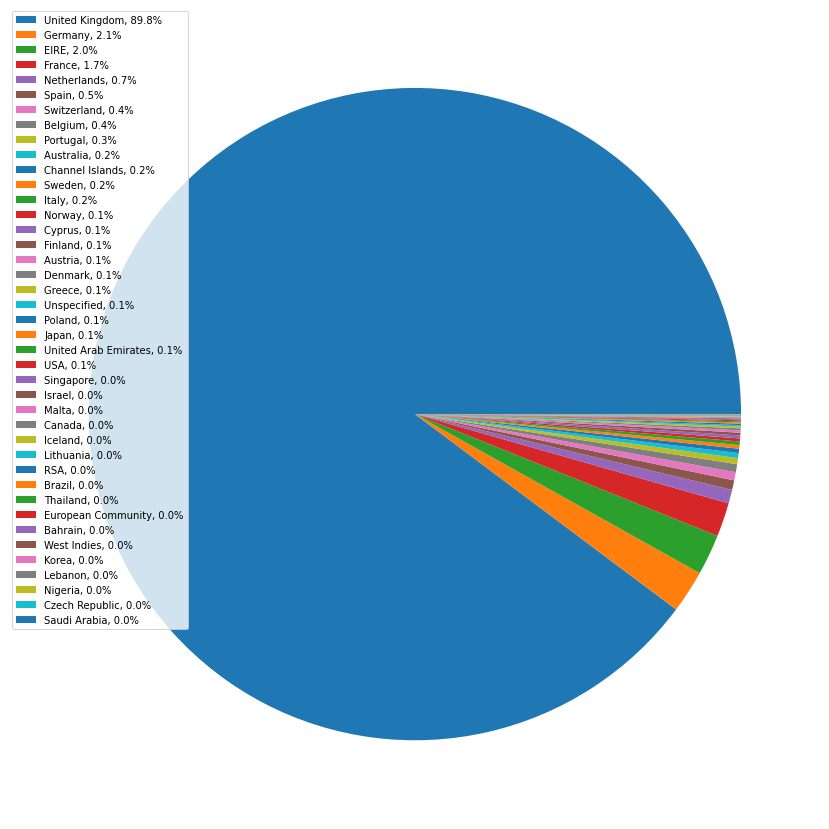

In [138]:
fig = plt.figure(figsize = (15,15))
patches, texts = plt.pie(sizes )
plt.legend(patches, labels, loc="best")
plt.show()

- customer ID has lot of none
- country has lot of purchase in UK
- quantity has negative values

In [7]:
data = data.dropna()
data = data[data['Quantity']>=0]
data = data[data['Price']>=0]

In [8]:
data.shape

(715226, 8)

In [9]:
data['TotalPrice'] = data['Quantity']*data['Price']
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['monthYear'] = data['InvoiceDate'].dt.year.astype(str) +"-"+ data['InvoiceDate'].dt.month.astype(str)

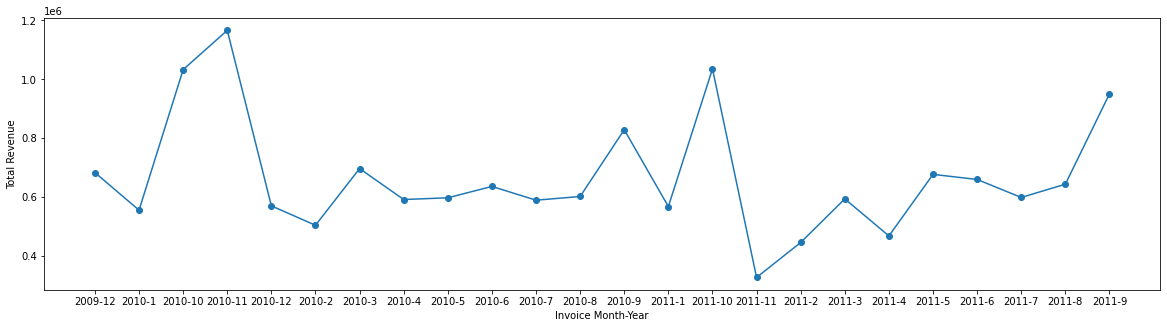

In [10]:
fig = plt.figure(figsize=(20,5))
grouped = data.groupby('monthYear')['TotalPrice'].sum().reset_index()
_=plt.plot_date(grouped['monthYear'], grouped['TotalPrice'], linestyle='solid')
_=plt.xlabel("Invoice Month-Year")
_=plt.ylabel("Total Revenue")

In [11]:
data.groupby('Country')['TotalPrice'].sum().reset_index().sort_values(by="TotalPrice", ascending=False).head()

,Country,TotalPrice
38,United Kingdom,1.323429e+07
10,EIRE,5.833226e+05
24,Netherlands,5.209230e+05
14,Germany,3.917900e+05
13,France,3.168800e+05


In [12]:
data.InvoiceDate.min(),data.InvoiceDate.max()

(Timestamp('2009-12-01 07:45:00'), Timestamp('2011-11-09 12:49:00'))

# Feature Engineering

## Model is being tested on out of time predictions

In [95]:
train_part1_split = data[data['InvoiceDate'] < pd.to_datetime("2011-09-10")]
train_part2_split = data[(data['InvoiceDate'] >= pd.to_datetime("2011-09-10")) &
                         (data['InvoiceDate'] < pd.to_datetime("2011-10-10"))]


test_part1_split = data[(data['InvoiceDate'] >= pd.to_datetime("2010-01-01")) & 
                        (data['InvoiceDate'] < pd.to_datetime("2011-10-10"))]
test_part2_split = data[(data['InvoiceDate'] >= pd.to_datetime("2011-10-10")) &
                         (data['InvoiceDate'] < pd.to_datetime("2011-11-10"))]

In [144]:
customers_train['FrequencySegment'].unique()

3

In [147]:
def transform_data(df1, df2, nQuantiles=3):
    result = df1.groupby("Customer ID").agg({'InvoiceDate': 'max', 'Invoice':'count', 'TotalPrice': 'sum'})\
                    .reset_index()\
                    .rename(columns={"InvoiceDate": "LastPurchaseDate",
                                     "Invoice": "Frequency",
                                     "TotalPrice": "Monetary"
                                    })
    _next_ = df2.groupby("Customer ID")["InvoiceDate"].min()\
                    .reset_index()\
                    .rename(columns={"InvoiceDate": "NextPurchaseDate"})
    result = result.merge(_next_, "left", "Customer ID")
    result['NextPurchaseDiff'] = (result['NextPurchaseDate'] - result['LastPurchaseDate']).dt.days
    result['Recency'] = (result['LastPurchaseDate'].max() - result['LastPurchaseDate']).dt.days
    result['NextPurchaseDiff'] = result['NextPurchaseDiff'].fillna(99999)
    result['RecencySegment'] = pd.qcut(result['Recency'].values, nQuantiles).codes + 1
    result['FrequencySegment'] = pd.qcut(result['Frequency'].values, nQuantiles).codes + 1
    result['MonetarySegment'] = pd.qcut(result['Monetary'].values, nQuantiles).codes + 1
    
    def invert_score(df, col):
        n = len(df[col].unique())
        mapper = {}
        for i in range(1, n+1):
            mapper[i] = n+1-i
        return mapper

    result['FrequencySegment'] = result['FrequencySegment'].map(invert_score(result, 'FrequencySegment'))
    result['MonetarySegment'] = result['MonetarySegment'].map(invert_score(result, 'MonetarySegment'))
    result['RFMScore'] = result['RecencySegment'] + result['FrequencySegment'] +\
                         result['MonetarySegment']
    result['RFMScoreGroup'] = result['RecencySegment'].apply(str) + result['FrequencySegment'].apply(str) +\
                         result['MonetarySegment'].apply(str)
    result['Segment'] = result['RFMScore'].apply(lambda x : "Low-Value" if x<=4 else ("Mid-Value" if x<=7 else "High-Value") )
    
    return result

In [168]:
customers_train = transform_data(train_part1_split, train_part2_split)
customers_test = transform_data(test_part1_split, test_part2_split)

In [169]:
customers_train.head()

,Customer ID,LastPurchaseDate,Frequency,Monetary,NextPurchaseDate,NextPurchaseDiff,Recency,RecencySegment,FrequencySegment,MonetarySegment,RFMScore,RFMScoreGroup,Segment
0,12346.0,2011-01-18 10:01:00,34,77556.46,NaT,99999.0,234,2,2,1,5,221,Mid-Value
1,12347.0,2011-08-02 08:48:00,164,3402.39,NaT,99999.0,38,1,1,1,3,111,Low-Value
2,12348.0,2011-04-05 10:47:00,48,1709.40,2011-09-25 13:13:00,173.0,157,2,2,1,5,221,Mid-Value
3,12349.0,2010-10-28 08:23:00,102,2671.14,NaT,99999.0,316,3,1,1,5,311,Mid-Value
4,12350.0,2011-02-02 16:01:00,17,334.40,NaT,99999.0,218,2,3,3,8,233,High-Value


<AxesSubplot: >

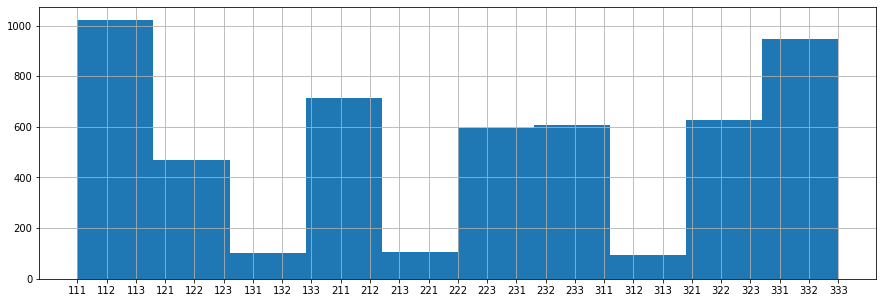

In [170]:
fig, ax = plt.subplots(figsize=(15,5))
customers_train.sort_values(by='RFMScoreGroup')['RFMScoreGroup'].hist(ax=ax)

- Based on above plots we can divide the customers using RFMScore into low-value(3-4), mid-value(5-7) and high-value (8-9)

In [171]:
customers_train.groupby("Segment").agg({"RFMScore":lambda x: list(np.unique(x))})

,RFMScore
Segment,
High-Value,"[8, 9]"
Low-Value,"[3, 4]"
Mid-Value,"[5, 6, 7]"


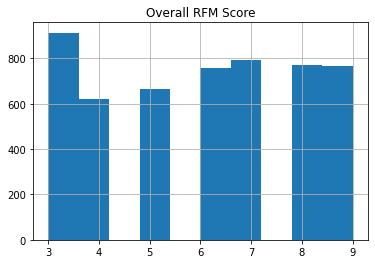

In [183]:
_ = customers_train['RFMScore'].hist()
_ = plt.title("Overall RFM Score")

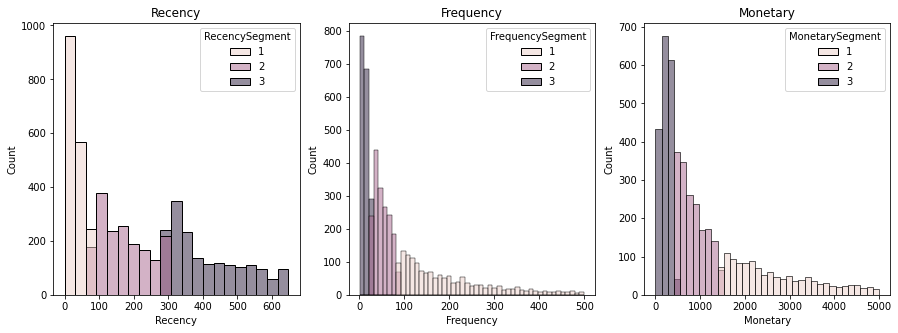

In [187]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data=customers_train, x="Recency", hue="RecencySegment", ax=ax[0])
sns.histplot(data=customers_train[customers_train['Frequency']<500], x="Frequency", hue="FrequencySegment", ax=ax[1])
sns.histplot(data=customers_train[customers_train['Monetary']<5000], x="Monetary", hue="MonetarySegment", ax=ax[2])

ax[0].title.set_text('Recency')
ax[1].title.set_text('Frequency')
ax[2].title.set_text('Monetary')

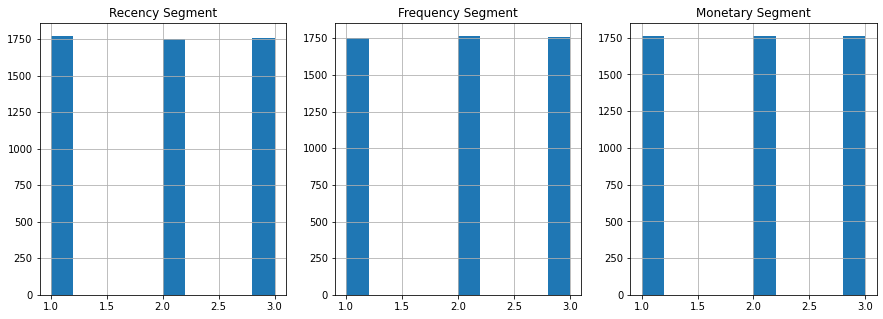

In [184]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
customers_train['RecencySegment'].hist(ax=ax[0])
customers_train['FrequencySegment'].hist(ax=ax[1])
customers_train['MonetarySegment'].hist(ax=ax[2])
ax[0].title.set_text('Recency Segment')
ax[1].title.set_text('Frequency Segment')
ax[2].title.set_text('Monetary Segment')

Text(0.5, 1.0, 'Segment Distribution')

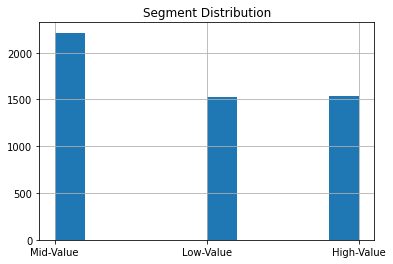

In [188]:
customers_train['Segment'].hist()
plt.title('Segment Distribution')

In [190]:
customers_train = pd.get_dummies(customers_train)
customers_test = pd.get_dummies(customers_test)

In [154]:
all([i==j for i,j in zip(customers_train.columns, customers_test.columns)])

True

In [155]:
sorted(customers_train['RFMScore'].unique())

[3, 4, 5, 6, 7, 8, 9]

In [156]:
customers_train.columns

Index(['Customer ID', 'LastPurchaseDate', 'Frequency', 'Monetary',
       'NextPurchaseDate', 'NextPurchaseDiff', 'Recency', 'RecencySegment',
       'FrequencySegment', 'MonetarySegment', 'RFMScore', 'RFMScoreGroup_111',
       'RFMScoreGroup_112', 'RFMScoreGroup_113', 'RFMScoreGroup_121',
       'RFMScoreGroup_122', 'RFMScoreGroup_123', 'RFMScoreGroup_131',
       'RFMScoreGroup_132', 'RFMScoreGroup_133', 'RFMScoreGroup_211',
       'RFMScoreGroup_212', 'RFMScoreGroup_213', 'RFMScoreGroup_221',
       'RFMScoreGroup_222', 'RFMScoreGroup_223', 'RFMScoreGroup_231',
       'RFMScoreGroup_232', 'RFMScoreGroup_233', 'RFMScoreGroup_311',
       'RFMScoreGroup_312', 'RFMScoreGroup_313', 'RFMScoreGroup_321',
       'RFMScoreGroup_322', 'RFMScoreGroup_323', 'RFMScoreGroup_331',
       'RFMScoreGroup_332', 'RFMScoreGroup_333', 'Segment_High-Value',
       'Segment_Low-Value', 'Segment_Mid-Value'],
      dtype='object')

# Model

In [192]:
customers_train[preds].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Frequency,5283.0,117.475487,282.410176,1.0,19.00,48.00,119.000,9180.00
Monetary,5283.0,2636.864663,12223.337903,0.0,318.04,782.95,2077.805,456780.49
Recency,5283.0,206.829264,175.130360,0.0,49.00,163.00,326.000,647.00
RecencySegment,5283.0,1.997918,0.817614,1.0,1.00,2.00,3.000,3.00
FrequencySegment,5283.0,2.001325,0.815993,1.0,1.00,2.00,3.000,3.00
MonetarySegment,5283.0,2.000000,0.816574,1.0,1.00,2.00,3.000,3.00
RFMScore,5283.0,5.999243,2.047246,3.0,4.00,6.00,8.000,9.00
Segment_High-Value,5283.0,0.290933,0.454236,0.0,0.00,0.00,1.000,1.00
Segment_Low-Value,5283.0,0.289987,0.453799,0.0,0.00,0.00,1.000,1.00
Segment_Mid-Value,5283.0,0.419080,0.493455,0.0,0.00,0.00,1.000,1.00


In [157]:
preds = [
           'Frequency', 'Monetary', 'Recency', 'RecencySegment',
           'FrequencySegment', 'MonetarySegment', 'RFMScore', 'Segment_High-Value',
           'Segment_Low-Value', 'Segment_Mid-Value'
        ]

In [158]:
customers_train['label'] = customers_train['NextPurchaseDiff']<30
customers_test['label'] = customers_test['NextPurchaseDiff']<30

In [159]:
models = []
models.append(("LogisticRegression", LogisticRegression()))
models.append(("GaussianNB", GaussianNB()))
models.append(("RandomForestClassifier", RandomForestClassifier()))
models.append(("xgboost", xgb.XGBClassifier(eval_metric='mlogloss')))

In [160]:
X_train, y_train = customers_train[preds], customers_train['label']
X_test, y_test = customers_test[preds], customers_test['label']
scaler = StandardScaler()
X_train[['Frequency', 'Monetary', 'Recency']] = scaler.fit_transform(X_train[['Frequency', 'Monetary', 'Recency']])
X_test[['Frequency', 'Monetary', 'Recency']] = scaler.transform(X_test[['Frequency', 'Monetary', 'Recency']])

model_results=[]
# For each model name and model in models
for model_name, model in models: 
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:,1]
    y_label = y_pred>0.5
    f1 = f1_score(y_test, y_label, average='macro')
    auc = roc_auc_score(y_test, y_pred)
    precision = precision_score(y_test, y_label, average='macro')
    recall = recall_score(y_test, y_label, average='macro')
    model_results.append([model_name, auc, f1, recall, precision])

model_score_df = pd.DataFrame(model_results, columns=['model_name', 'auc', 'f1_score', 'recall', 'precision']
                             ).set_index("model_name")

<ipython-input-160-7d24564341db>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['Frequency', 'Monetary', 'Recency']] = scaler.fit_transform(X_train[['Frequency', 'Monetary', 'Recency']])
<ipython-input-160-7d24564341db>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[['Frequency', 'Monetary', 'Recency']] = scaler.transform(X_test[['Frequency', 'Monetary', 'Recency']])


# Evaluation

In [161]:
model_score_df

,auc,f1_score,recall,precision
model_name,,,,
LogisticRegression,0.951074,0.602223,0.565516,0.909506
GaussianNB,0.936811,0.585711,0.873256,0.593203
RandomForestClassifier,0.925347,0.679638,0.647342,0.736174
xgboost,0.927976,0.661869,0.644546,0.685385


# Hyper-param tuning

In [162]:
parameter = {
    'max_depth':range(3,10,2), 
    'min_child_weight':range(2,5,1),
    'learning_rate': [0.01, 0.05, 0.1]
    }

grid_search = GridSearchCV(estimator = xgb.XGBClassifier(eval_metric='mlogloss'),
                             param_grid = parameter,
                             scoring='f1_macro',
                             n_jobs=-1,
                             cv=StratifiedKFold( n_splits=5, shuffle=True)
                            )

grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     import...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': range(3, 10, 2),
                         'min_child_weight': range(2, 5)},
             scoring='f1_macro')

In [163]:
grid_search.best_params_, grid_search.best_score_

({'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 4},
 0.7152776558799634)

In [164]:
new_xgb = xgb.XGBClassifier(eval_metric='logloss', 
                            max_depth=grid_search.best_params_['max_depth'], 
                            min_child_weight=grid_search.best_params_['min_child_weight'],
                            learning_rate=grid_search.best_params_['learning_rate']
                         ).fit(X_train, y_train)
y_pred = new_xgb.predict_proba(X_test)[:,1]
y_label = y_pred>0.5
f1 = f1_score(y_test, y_label, average='macro')
auc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_label, average='macro')
recall = recall_score(y_test, y_label, average='macro')
model_results.append(['optimized_xgb', auc, f1, recall, precision])


In [165]:
model_score_df = pd.DataFrame(model_results, columns=['model_name', 'auc', 'f1_score', 'recall', 'precision']
                             ).set_index("model_name")
model_score_df

,auc,f1_score,recall,precision
model_name,,,,
LogisticRegression,0.951074,0.602223,0.565516,0.909506
GaussianNB,0.936811,0.585711,0.873256,0.593203
RandomForestClassifier,0.925347,0.679638,0.647342,0.736174
xgboost,0.927976,0.661869,0.644546,0.685385
optimized_xgb,0.937074,0.688990,0.646588,0.778549


# Predictions